In [129]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import MNIST

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [136]:
def apply_field(img, field):
    """Applies specified deformation to an image."""
    img = img.numpy()
    
    # set up adjusted coordinates
    h, w = img.shape
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    coords = np.stack((x, y), axis=-1)
    coords_adj = coords + field

    # remap pixels
    img_adj = cv2.remap(img, coords_adj[:,:,0].astype(np.float32),
                        coords_adj[:,:,1].astype(np.float32), 
                        interpolation=cv2.INTER_LINEAR)
    
    img_adj = torch.Tensor(img_adj)
    return(img_adj)

def loss(img1, img2, field, lmbda):
    """Calculates loss associated with image reconstruction and associated field."""
    
    # approximate field gradient
    diff_x = torch.diff(field[:,:,0], axis=0)
    diff_y = torch.diff(field[:,:,1], axis=1)
    diff_x = F.pad(diff_x, (0, 0, 1, 0), mode='constant')
    diff_y = F.pad(diff_y, (1, 0, 0, 0), mode='constant')

    # calculate loss
    loss_sim = torch.sum((img1 - img2)**2)
    loss_smooth = torch.sum(diff_x**2 + diff_y**2)
    loss_total = loss_sim + lmbda * loss_smooth
    return(loss_total.item())

In [137]:
# load data
transform = torchvision.transforms.ToTensor()
mnist_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist_dataset, batch_size=1, shuffle=True)

# generate random demo field
field = np.random.uniform(-1, 1, (28, 28, 2))

# set up demo image
img, _ = next(iter(dataloader))
img = img.squeeze()

# apply deformation field
img_adj = apply_field(img, field)

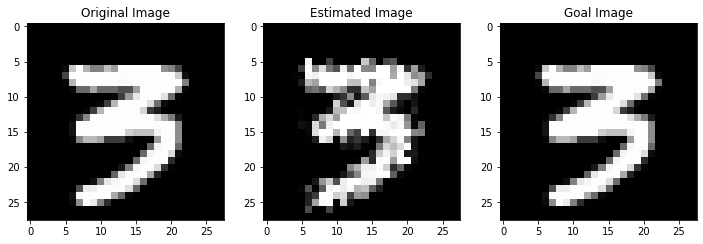

In [144]:
# display original/transformed images
img_goal = img

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(img_adj, cmap='gray')
plt.title('Estimated Image')

plt.subplot(1, 3, 3)
plt.imshow(img_goal, cmap='gray')
plt.title('Goal Image')

plt.show()

In [147]:
lmbda = 0.01
img1 = torch.Tensor(img)
img2 = torch.Tensor(img_adj)
field2 = torch.Tensor(field)

loss(img1, img2, field2, lmbda)

30.014240264892578